In [1]:
import skimage
import os
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import cv2
from scipy import io
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
from pytorch_msssim import ssim

sys.path.insert(0, os.path.abspath('..'))
import utils
from incode_experiments import lin_inverse
from incode_experiments import utils as incode_utils
from incode_experiments.models import INR
from incode_experiments import dataio

In [43]:
parser = argparse.ArgumentParser(description='LG_INCODE')

# Shared Parameters
parser.add_argument('--input', type=str, default='../data/img_377_ct_reconstruction.png', help='Input image path')
parser.add_argument('--inr_model', type=str, default='lg_incode', help='[incode, lg_incode]')
parser.add_argument('--lr',type=float, default=2e-4, help='Learning rate')
parser.add_argument('--using_schedular', type=bool, default=True, help='Whether to use schedular')
parser.add_argument('--scheduler_b', type=float, default=0.4, help='Learning rate scheduler')
parser.add_argument('--niters', type=int, default=2001, help='Number if iterations')
parser.add_argument('--steps_til_summary', type=int, default=200, help='Number of steps till summary visualization')
parser.add_argument('--downsample', type=int, nargs='+', default=(1, 2), help='Partition factors for Local-Global INCODE')

# CT Parameters
parser.add_argument('--proj', type=int, default=150, help='Number of CT measurements')

# INCODE Parameters
parser.add_argument('--a_coef',type=float, default=0.1993, help='a coeficient')
parser.add_argument('--b_coef',type=float, default=0.0196, help='b coeficient')
parser.add_argument('--c_coef',type=float, default=0.0588, help='c coeficient')
parser.add_argument('--d_coef',type=float, default=0.0269, help='d coeficient')


args = parser.parse_args(args=[])

groups = np.prod(args.downsample) if 'lg' in args.inr_model else 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [44]:
thetas = torch.tensor(np.linspace(0, 180, args.proj, dtype=np.float32)).to(device)
im = incode_utils.normalize(plt.imread(args.input).astype(np.float32), True)[..., 0]
H, W = im.shape
gt = torch.tensor(im)[None, None, ...].to(device)

with torch.no_grad():
    sinogram = lin_inverse.radon(gt, thetas).detach().cpu().numpy()
    sinogram_gt = torch.tensor(sinogram).to(device)

In [45]:
image_dataset = dataio.ImageFileFromArray(im)
image_dataset = dataio.ImplicitSingle2DWrapper(image_dataset, downsample=tuple(args.downsample) if 'lg' in args.inr_model else None)

image_dataloader = DataLoader(image_dataset, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)

## Defining Model

### Model Configureations

In [46]:
### Harmonizer Configurations
MLP_configs={'task': 'image',
             'model': 'resnet34',
             'truncated_layer':5,
             'in_channels': 64,             
             'hidden_channels': [64, 32, 12] if args.inr_model == 'lg_incode' else [64, 32, 4],
             'mlp_bias':0.3120,
             'activation_layer': nn.SiLU,
             'GT': sinogram_gt[None, None, ...].expand(1, 3, sinogram_gt.shape[0], sinogram_gt.shape[1])
            }

### Model Configurations
if 'lg_' in args.inr_model:
    additional_kwargs = {'groups': np.prod(args.downsample), 'hidden_features': 230 * 2 * 1, 'global_hidden_features': 300}
else:
    additional_kwargs = {'hidden_features': 326}

model = INR(args.inr_model).run(in_features=2,
                                out_features=1, 
                                hidden_layers=1 if 'lg' in args.inr_model else 3,
                                first_omega_0=30.0,
                                hidden_omega_0=30.0,
                                pos_encode_configs={'type': None}, 
                                MLP_configs = MLP_configs,
                                **additional_kwargs
                               ).to(device)

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

if args.inr_model == 'lg_incode':
    print('Total Params:', count_parameters(model.global_net) + count_parameters(model.net) + count_parameters(model.agg_func) + count_parameters(model.aux_mlp))
    print('Global Params:', count_parameters(model.global_net) + count_parameters(model.agg_func) + count_parameters(model.aux_mlp))
    print('Local Params:', count_parameters(model.net))
elif 'incode' in args.inr_model:
    print('Total Params', count_parameters(model.net) + count_parameters(model.aux_mlp))

Total Params: 328068
Global Params: 219966
Local Params: 108102


## Training Code

In [48]:
optim = torch.optim.Adam(lr=args.lr, params=[p[1] for p in model.named_parameters() if 'feature_extractor' not in p[0]])

scheduler = lr_scheduler.LambdaLR(optim, lambda x: args.scheduler_b ** min(x / args.niters, 1))

# Initialize lists for PSNR and MSE values
psnr_values = []
mse_array = torch.zeros(args.niters, device='cuda')

# Initialize best loss value as positive infinity
best_loss = torch.tensor(float('inf'))

loss_array = []

  0%|          | 0/2001 [00:00<?, ?it/s]

Epoch: 0 | Loss: 3802.75586 | PSNR: 9.27512


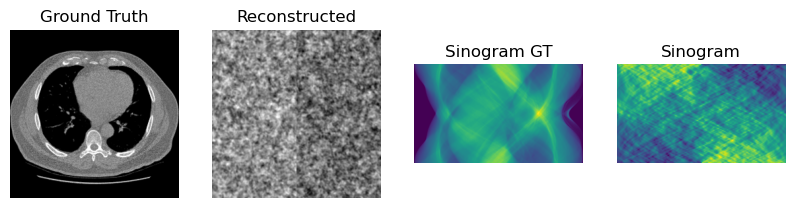

Epoch: 200 | Loss: 0.24330 | PSNR: 27.17175


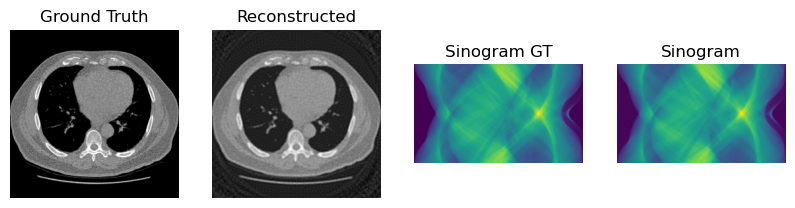

Epoch: 400 | Loss: 0.11066 | PSNR: 28.77727


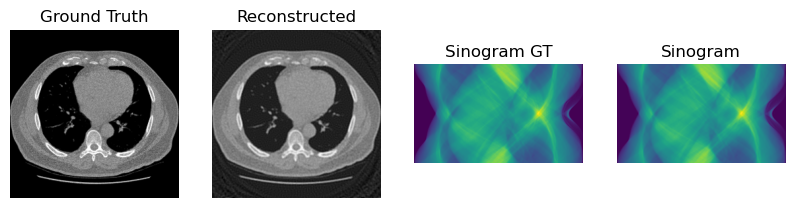

Epoch: 600 | Loss: 0.07931 | PSNR: 29.48691


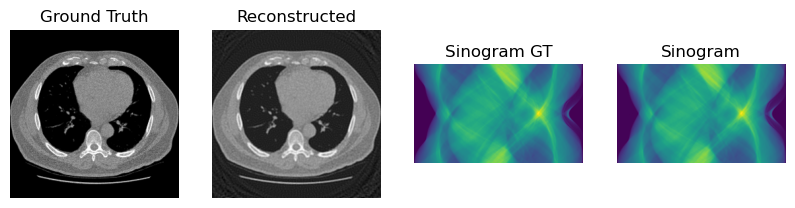

Epoch: 800 | Loss: 0.04798 | PSNR: 30.07614


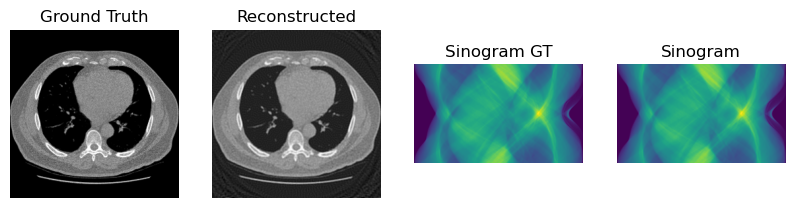

Epoch: 1000 | Loss: 0.03613 | PSNR: 30.43159


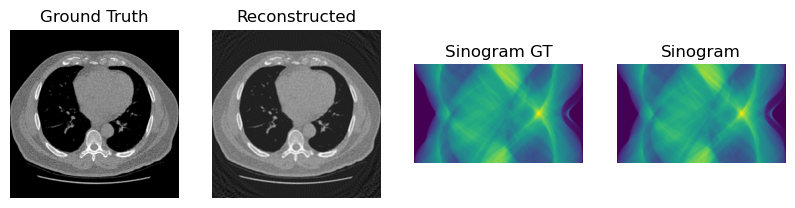

Epoch: 1200 | Loss: 0.02957 | PSNR: 30.65935


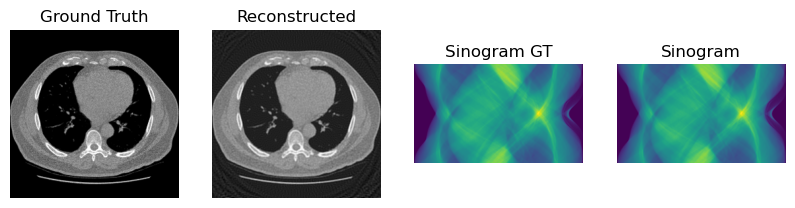

Epoch: 1400 | Loss: 0.02394 | PSNR: 30.87917


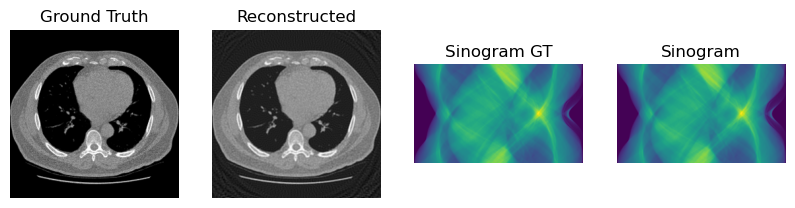

Epoch: 1600 | Loss: 0.02014 | PSNR: 31.04653


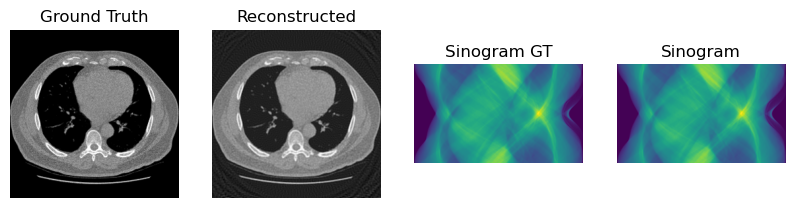

Epoch: 1800 | Loss: 0.01775 | PSNR: 31.15882


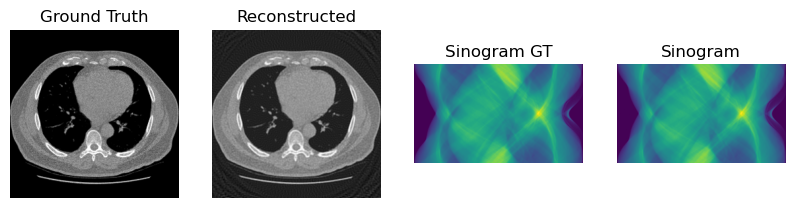

Epoch: 2000 | Loss: 0.01532 | PSNR: 31.28089


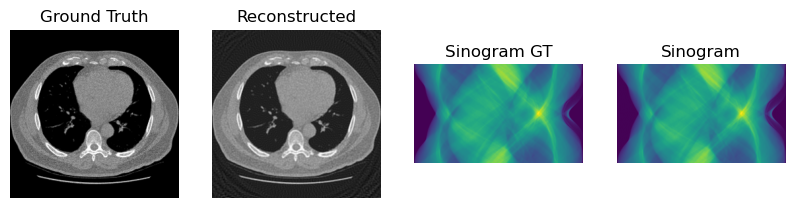

--------------------
Max PSNR: 31.28089141845703
--------------------


In [49]:
for step in tqdm(range(args.niters)):
    in_dict, gt_dict = next(iter(image_dataloader))
    b_coords = in_dict['coords'].cuda()
        
    model_output, coef = model(b_coords)
    
    model_output = dataio.lin2img(model_output, (H, W), image_dataset.gt_slices).cuda()

    # Compute the sinogram of output
    sinogram_output = lin_inverse.radon(model_output, thetas)

    # Calculate the output loss
    output_loss = ((sinogram_output - sinogram_gt)**2).mean()
    loss_array.append(output_loss.item())
    if 'incode' in args.inr_model:
        # Calculate regularization loss for 'incode' model
        all_coeffs = []
        for i in range(0, len(coef[0]), 4):
            all_coeffs.append(coef[0][i:i+4])

        reg_loss = args.a_coef * torch.relu(-all_coeffs[0][0]) + \
                   args.b_coef * torch.relu(-all_coeffs[0][1]) + \
                   args.c_coef * torch.relu(-all_coeffs[0][2]) + \
                   args.d_coef * torch.relu(-all_coeffs[0][3])

        for coeffs in all_coeffs[1:]:
            reg_loss += args.a_coef * torch.relu(-coeffs[0]) + \
                       args.b_coef * torch.relu(-coeffs[1]) + \
                       args.c_coef * torch.relu(-coeffs[2]) + \
                       args.d_coef * torch.relu(-coeffs[3])

        # Total loss for 'incode' model
        loss = output_loss + reg_loss
    else:
        # Total loss for other models
        loss = output_loss


    # Perform backpropagation and update model parameters
    optim.zero_grad()
    loss.backward()
    optim.step()

    # Adjust learning rate using a scheduler if applicable
    if args.using_schedular:
        scheduler.step()

    # Calculate PSNR
    with torch.no_grad():
        mse_array[step] = ((gt - model_output)**2).mean().item()
        psnr = -10*torch.log10(mse_array[step])
        psnr_values.append(psnr.item())

        
    # Check if the current iteration's loss is the best so far
    if (mse_array[step] < best_loss) or (step == 0):
        best_loss = mse_array[step]
        model_output = (model_output - model_output.min()) / (model_output.max() - model_output.min())
        best_img = model_output

    # Display intermediate results at specified intervals
    if step % args.steps_til_summary == 0:
        print("Epoch: {} | Loss: {:.5f} | PSNR: {:.5f}".format(step, loss.item(), psnr.item())) 
        
        ### Plot                                                                   
        fig, axes = plt.subplots(1, 4, figsize=(10, 10))
        subplot_info = [
            {'title': 'Ground Truth', 'image': im, 'cmap': 'gray'},
            {'title': 'Reconstructed', 'image': best_img[0][0].cpu().detach().numpy(), 'cmap': 'gray'},
            {'title': 'Sinogram GT', 'image': sinogram_gt.cpu().detach().numpy(), 'cmap': 'viridis'},
            {'title': 'Sinogram', 'image': sinogram_output.cpu().detach().numpy(), 'cmap': 'viridis'}]

        for ax, info in zip(axes, subplot_info):
            ax.set_title(info['title'])
            ax.imshow(info['image'], cmap=info['cmap'])
            ax.axis('off')
        plt.show()



# Print maximum PSNR achieved during training
print('--------------------')
print('Max PSNR:', max(psnr_values))
print('--------------------')

# Convergance Rate

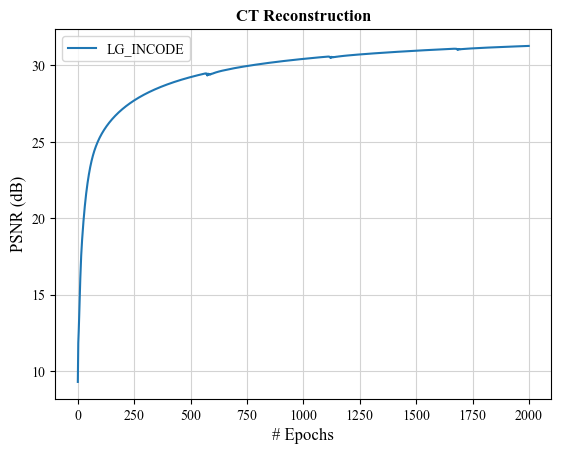

In [51]:
font = {'font': 'Times New Roman', 'size': 12}

plt.figure()
axfont = {'family' : 'Times New Roman', 'weight' : 'regular', 'size'   : 10}
plt.rc('font', **axfont)

plt.plot(np.arange(len(psnr_values[:-1])), psnr_values[:-1], label = f"{(args.inr_model).upper()}")
plt.xlabel('# Epochs', fontdict=font)
plt.ylabel('PSNR (dB)', fontdict=font)
plt.title('CT Reconstruction', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
plt.legend()
plt.grid(True, color='lightgray')

plt.show()